## BME 인공지능 3조 (ASL 인식 모델 구현 - training ver.)
손모양(미국 수화) 사진을 이용해 해당 수화의 의미(알파벳)를 알려주는 모델 구현

###### BME 인공지능 실습 자료인 ch06_SimpleConvNet.ipynb 을 참고/수정하여 제작되었음을 밝힙니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
path_train = '/content/drive/MyDrive/ASL data/train'
path_valid = '/content/drive/MyDrive/ASL data/valid'

### Image Data Loader 생성 
- pytorch에서는 image data를 편하게 가져올 수 있는 다양한 도구들을 제공합니다.
- ImageFolder는 그 중 하나로, image data를 폴더별로 정리한 경우 자동으로 폴더이름을 label로 하여 loader를 정의합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batch_size = 32

train_transforms = transforms.Compose(
      [
          transforms.Resize((64,64)),
          transforms.ToTensor(),
      ]
    )

trainset = torchvision.datasets.ImageFolder(root = path_train,transform=train_transforms)
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=train_transforms)

train_iter = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
valid_iter = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=False)

In [ ]:
tgtnames = trainset.classes

torch.Size([32])
torch.Size([32, 3, 64, 64])


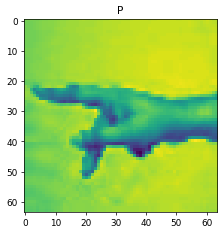

In [ ]:
dataiter=iter(train_iter)
images, labels = dataiter.next()
print(labels.shape)
print(images.shape)
I = images[0][0].numpy()
plt.figure(dpi=64)
plt.imshow(I)
plt.title(tgtnames[labels[0]])
plt.show()

### CNN model 불러오기

In [ ]:
import torchvision.models as models
net = models.resnext50_32x4d()
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:

net.fc = torch.nn. Linear(in_features=2048, out_features=26, bias=True)

net.layer2 = torch.nn.Sequential(
    net.layer2[0],
    net.layer2[1],
    net.layer2[2],
    net.layer2[3],
    torch.nn.Dropout(0.2)
)

net.layer3 = torch.nn.Sequential(
    net.layer3[0],
    net.layer3[1],
    net.layer3[2],
    net.layer3[3],
    net.layer3[4],
    net.layer3[5],
    torch.nn.Dropout(0.2)
)

net.layer4 = torch.nn.Sequential(
    net.layer4[0],
    net.layer4[1],
    torch.nn.Dropout(0.02),
    net.layer4[2]
)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

### Hyperparameter 설정하기

In [ ]:
# setting hyper-parameters
batch_size = 320
learning_rate = 0.0038
num_epochs = 120

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate, weight_decay=0.000025) # sgd

### Model 학습시키기

In [ ]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs+1):
    i=0
    l_epoch = 0
    correct = 0
    net.train()
    for X,y in train_iter:
        i=i+1
        X,y = X.to(device),y.to(device)
        y_hat=net(X)
        correct += (y_hat.argmax(dim=1)==y).sum()
        l=loss(y_hat,y)
        l_epoch+=l
        alg.zero_grad()
        l.backward()
        alg.step()

    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
    accs_train = np.append(accs_train,correct.cpu()/len(trainset))

    correct = 0
    net.eval()
    for X,y in valid_iter:
        X,y = X.to(device),y.to(device)
        y_hat = net(X)
        correct += (y_hat.argmax(dim=1)==y).sum()

    accs_valid = np.append(accs_valid,correct.cpu()/len(validset))

    plt.figure(2,dpi=80)
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='upper left')
    plt.title('epoch: %d '%(epoch))
    plt.savefig('loss_curve.png')

    plt.close(2)

    if epoch%5 == 0:
        print('epoch: %d '%(epoch))
        print('train loss: ',loss_train[-1])
        print('train accuracy: ',accs_train[-1])
        print('valid accuracy: ',accs_valid[-1])

epoch: 0 
train loss:  3.3610014481977983
train accuracy:  0.04467680677771568
valid accuracy:  0.039393939077854156
epoch: 5 
train loss:  2.939229560620857
train accuracy:  0.14543725550174713
valid accuracy:  0.18484848737716675
epoch: 10 
train loss:  1.8896835789535984
train accuracy:  0.46720531582832336
valid accuracy:  0.5292929410934448
epoch: 15 
train loss:  1.091723124186198
train accuracy:  0.6927281618118286
valid accuracy:  0.6939393877983093
epoch: 20 
train loss:  0.7410848212964607
train accuracy:  0.793013334274292
valid accuracy:  0.7434343695640564
epoch: 25 
train loss:  0.5560582478841146
train accuracy:  0.8395912647247314
valid accuracy:  0.800000011920929
epoch: 30 
train loss:  0.4157575260509144
train accuracy:  0.8816539645195007
valid accuracy:  0.842424213886261
epoch: 35 
train loss:  0.3013336586229729
train accuracy:  0.911121666431427
valid accuracy:  0.8494949340820312
epoch: 40 
train loss:  0.20813353856404623
train accuracy:  0.9443916082382202
va

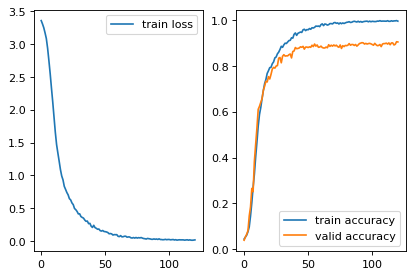

In [ ]:
plt.figure(2,dpi=80)
plt.subplot(121)
plt.plot(loss_train,label='train loss')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(accs_train,label='train accuracy')
plt.plot(accs_valid,label='valid accuracy')
plt.legend(loc='lower right')
plt.show()

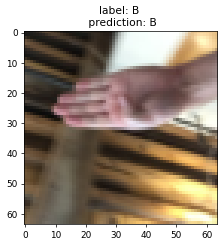

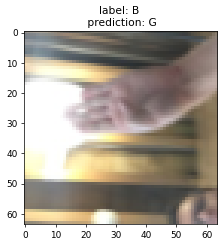

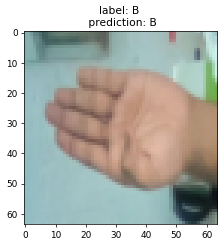

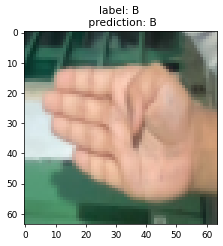

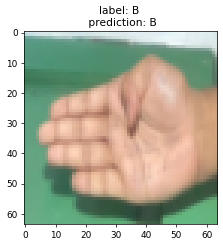

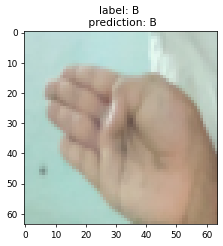

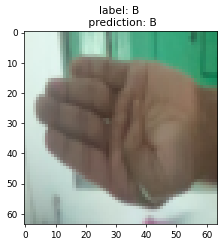

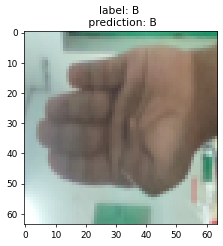

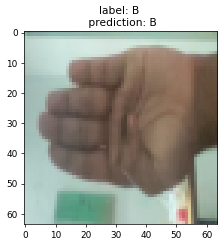

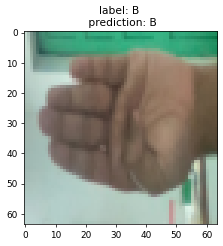

In [ ]:
i = 0
y_list = np.array([])
y_hat_list = np.array([])
for X,y in valid_iter:
  X=X.to(device)
  y_hat = net(X)    
  y_hat = y_hat.argmax(dim=1)

  y_list = np.append(y_list,y)
  y_hat_list = np.append(y_hat_list,y_hat.cpu().numpy())

  if i == 2:
    for n in range(i,i+10):
      plt.figure(dpi=64)
      plt.imshow(X[n].T.cpu())
      plt.title('label: %s \n prediction: %s'%(tgtnames[y[n]],tgtnames[y_hat[n]]))
      plt.pause(.0001)
  i=i+1


In [ ]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

In [ ]:
print(classification_report(
    y_list,
    y_hat_list,
    target_names=tgtnames))

              precision    recall  f1-score   support

           A       0.92      0.88      0.90        50
           B       0.81      0.95      0.88        44
           C       0.97      0.76      0.85        42
           D       0.95      0.86      0.90        42
           E       0.86      0.97      0.92        39
           F       0.90      0.95      0.92        39
           G       0.80      0.85      0.83        39
           H       1.00      0.82      0.90        39
           I       0.92      0.92      0.92        39
           J       1.00      0.86      0.93        22
           K       0.91      1.00      0.96        32
           L       0.88      0.97      0.93        39
           M       0.93      0.97      0.95        39
           N       0.97      0.88      0.93        42
           O       0.86      0.92      0.89        39
           P       0.91      0.86      0.88        35
           Q       0.93      0.95      0.94        39
           R       0.88    

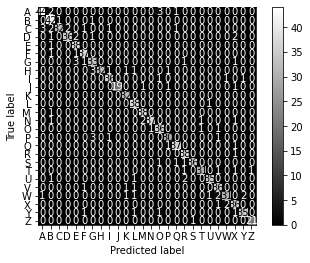

In [ ]:
cm = confusion_matrix(
    y_list,
    y_hat_list,
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tgtnames,
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1],cmap='gray')

## 모델 저장하기

In [ ]:
torch.save(net.state_dict(),'/content/drive/MyDrive/Colab Notebooks/BME Team3.params')
clone = net
clone.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/BME Team3.params"))
clone.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1